In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'asamadan'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'


- List the tables in the database

In [ ]:
pd.read_sql_query('select * from information_schema.tables', con)

In [9]:
# read tables and set 'subject_id' as index
Tables = ['admissions', 
          'patients', 
          'ICUstays',
          'diagnoses_icd',
          'procedures_icd',
          'callout', 
          'noteevents']
for x in Tables:
    exec("%s = pd.read_sql('select * from %s', con).set_index('subject_id', drop=False)"%(x,x))
        

## Merge the tables
- Admissions
- Patients
- ICUstays
- Diagnosis
    - There are multiple diagnosis for each patient. For now, the top diagnosis is used
- Callout
- Procedures_icd
    - There are multiple procedures for each patient. For now, the top diagnosis is used


In [10]:
diagnoses_icd  = diagnoses_icd.groupby(diagnoses_icd.index).apply(lambda x:x[x['seq_num'] == 1])
procedures_icd = procedures_icd.groupby(procedures_icd.index).apply(lambda x:x[x['seq_num'] == 1])
# # confirming that only the top diagnosis is returned 
# diagnoses_icd.seq_num.value_counts()
# procedures_icd.seq_num.value_counts()


In [11]:
# Merge the tables
import functools

# first merge admissions with patient based on 'subject_id'
admissions       = pd.merge(admissions, patients[patients.columns.difference(admissions.columns)],
                            how='left', left_index=True, right_index=True)

# set 'hadm_id' as index for the remaning tables and admissions
for x in ['admissions', 'ICUstays', 'diagnoses_icd', 'callout', 'noteevents']:
    eval("%s.set_index('hadm_id', drop=False, inplace=True)"%x)
    
# then, merge the resulting admissions with the rest of the tables using 'hadm_id'
dfs              = [admissions, ICUstays, diagnoses_icd, callout, noteevents]
# Data             = [pd.merge(left,right, how='left', on='subject_id') for left, right in zip(dfs, dfs[1:])]
Data             = functools.reduce(lambda left,right: 
                                    pd.merge(left,right[right.columns.difference(left.columns)], 
                                             how='left', left_index=True, right_index=True), dfs)


In [12]:
# get rid of erronous notes 
Data = Data.loc[Data.iserror !='1']

### Return the frequency of word 'pain' in the notes and add the result as a new col to 'Data' DF

In [13]:
PainCount = Data.text.str.lower().str.count('pain')
Data['PainCount'] = PainCount

# the 'Pain_no_Pain' col indicates where pain is mentioned or not (binary)
Data['Pain_no_Pain'] = PainCount>0

### How many admissions have notes with 'Pain'

In [39]:
a = sum(Data.groupby(['hadm_id'])['Pain_no_Pain'].sum()>0)/len(Data.hadm_id.unique())
print("%.2f%% of admissions have the 'Pain' mentioned at least in one of the corresponding notes"% (a*100))


83.91% of admissions have the 'Pain' mentioned at least in one of the corresponding notes


/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


### How many admissions are there per category


In [52]:
adm_per_cat = Data.groupby(['category'])['hadm_id'].nunique()

- How many admissions in each category have 'Pain'
    - there are multiple text for each admission. We want to identify admissions that have 'Pain' mentioned at least once in one of their corresponding texts 
    - next we want to compute the percentages of admissions within each category that have 'Pain' in their texts 

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


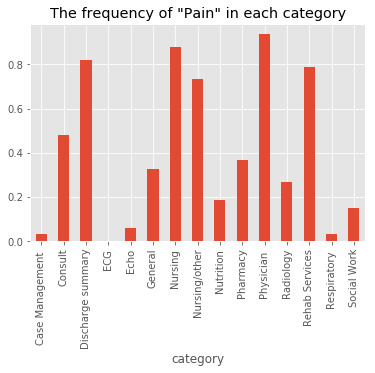

In [123]:
pain_per_adm_cat = (Data.groupby(['category','hadm_id'])['Pain_no_Pain'].sum()>0)
pain_per_adm_cat = pain_per_adm_cat.groupby(['category']).sum()/ adm_per_cat
pain_per_adm_cat.plot(kind = 'bar', title = 'The frequency of "Pain" in each category')


### Overall frequency of 'Pain' per diagnosis? 
- there is a large list of diagnosis that is needed to be consolidated into a shorter list with hierarchical structure for which higher levels presents more generic categries 


In [192]:
# Compute Age
from __future__ import division
Age = (Data.admittime-Data.dob)/np.timedelta64(1,'Y')
Age.loc[np.logical_and(Age>=0, Age<=1)]   = 1
Age.loc[np.logical_and(Age>1, Age<=25)]  = 2
Age.loc[np.logical_and(Age>25, Age<=50)] = 3
Age.loc[np.logical_and(Age>50, Age<=75)] = 4
Age.loc[np.logical_and(Age>75, Age<=90)] = 5
Age.loc[Age<0]                           = 6
# Data.drop(['admittime','dob'], axis=1, inplace=True)
Data['Age'] = Age

In [193]:
Data['Age'].value_counts()
# 'Age' in Data.columns


4.0    1244162
5.0     604751
1.0     427748
3.0     385118
6.0      84014
2.0      47243
Name: Age, dtype: int64

In [194]:
adm_per_age = Data.groupby(['Age'])['hadm_id'].nunique()
(Data.groupby(['Age','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['Age']).sum()/ adm_per_age

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


Age
1.0    0.148212
2.0    0.924896
3.0    0.941106
4.0    0.953926
5.0    0.950241
6.0    0.941896
dtype: float64

In [197]:
adm_per_age

Age
1.0     8110
2.0     1438
3.0     9203
4.0    24526
5.0    13083
6.0     2616
Name: hadm_id, dtype: int64

In [198]:
Data.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'dob', 'dod',
       'dod_hosp', 'dod_ssn', 'expire_flag', 'gender', 'dbsource',
       'first_careunit', 'first_wardid', 'icustay_id', 'intime',
       'last_careunit', 'last_wardid', 'los', 'outtime', 'icd9_code',
       'seq_num', 'acknowledge_status', 'acknowledgetime', 'callout_outcome',
       'callout_service', 'callout_status', 'callout_wardid', 'createtime',
       'curr_careunit', 'curr_wardid', 'currentreservationtime',
       'discharge_wardid', 'firstreservationtime', 'outcometime',
       'request_cdiff', 'request_mrsa', 'request_resp', 'request_tele',
       'request_vre', 'submit_careunit', 'submit_wardid', 'updatetime',
       'category', 'cgid', 'c

### Pain Frequency w.r.t Age

In [195]:
(Data.groupby(['Age','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['Age']).sum()

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


Age
1.0     1202.0
2.0     1330.0
3.0     8661.0
4.0    23396.0
5.0    12432.0
6.0     2464.0
Name: Pain_no_Pain, dtype: float64

### Pain Frequency w.r.t. admission type

In [205]:
adm_per_type = Data.groupby(['admission_type'])['hadm_id'].nunique()
(Data.groupby(['admission_type','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['admission_type']).sum()/ adm_per_type

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


admission_type
ELECTIVE     0.945367
EMERGENCY    0.946400
NEWBORN      0.144856
URGENT       0.931886
dtype: float64

### Pain Frequency w.r.t. admission location

In [207]:
adm_per_type = Data.groupby(['admission_location'])['hadm_id'].nunique()
(Data.groupby(['admission_location','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['admission_location']).sum()/ adm_per_type

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


admission_location
** INFO NOT AVAILABLE **     0.093137
CLINIC REFERRAL/PREMATURE    0.817320
EMERGENCY ROOM ADMIT         0.958908
HMO REFERRAL/SICK            0.156863
PHYS REFERRAL/NORMAL DELI    0.620200
TRANSFER FROM HOSP/EXTRAM    0.960028
TRANSFER FROM OTHER HEALT    0.971831
TRANSFER FROM SKILLED NUR    0.926740
TRSF WITHIN THIS FACILITY    1.000000
dtype: float64

### Pain Frequency w.r.t. discharge location


In [210]:
adm_per_type = Data.groupby(['discharge_location'])['hadm_id'].nunique()
(Data.groupby(['discharge_location','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['discharge_location']).sum()/ adm_per_type

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


discharge_location
DEAD/EXPIRED                 0.855313
DISC-TRAN CANCER/CHLDRN H    0.895366
DISC-TRAN TO FEDERAL HC      1.000000
DISCH-TRAN TO PSYCH HOSP     0.914798
HOME                         0.679781
HOME HEALTH CARE             0.917210
HOME WITH HOME IV PROVIDR    0.970149
HOSPICE-HOME                 0.985075
HOSPICE-MEDICAL FACILITY     0.986928
ICF                          0.914894
LEFT AGAINST MEDICAL ADVI    0.882192
LONG TERM CARE HOSPITAL      0.976573
OTHER FACILITY               0.888889
REHAB/DISTINCT PART HOSP     0.976357
SHORT TERM HOSPITAL          0.464798
SNF                          0.971836
SNF-MEDICAID ONLY CERTIF     1.000000
dtype: float64

### Pain Frequency w.r.t. insurance 

In [211]:
adm_per_type = Data.groupby(['insurance'])['hadm_id'].nunique()
(Data.groupby(['insurance','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['insurance']).sum()/ adm_per_type

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


insurance
Government    0.772855
Medicaid      0.780294
Medicare      0.951763
Private       0.718625
Self Pay      0.836334
dtype: float64

In [212]:
adm_per_type = Data.groupby(['gender'])['hadm_id'].nunique()
(Data.groupby(['gender','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['gender']).sum()/ adm_per_type

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


gender
F    0.832206
M    0.844492
dtype: float64

In [213]:
adm_per_type = Data.groupby(['marital_status'])['hadm_id'].nunique()
(Data.groupby(['marital_status','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['marital_status']).sum()/ adm_per_type

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


marital_status
DIVORCED             0.954560
LIFE PARTNER         1.000000
MARRIED              0.951731
SEPARATED            0.961471
SINGLE               0.929229
UNKNOWN (DEFAULT)    0.907246
WIDOWED              0.958536
dtype: float64

In [354]:
import sys
import os, imp
# sys.path.remove('/home/asamadan/Documents/HST953/icd9')
sys.path.append('/home/asamadan/Documents/HST953/icd9_')
from icd9_ import ICD9
from structured_data_utils import clean_icd9_code
from icd9_categories import icd_categories
a = Data.icd9_code.apply(lambda x: clean_icd9_code(str(x)))
Data['ICD9_categories'] = a.apply(icd_categories)

In [356]:
Data.ICD9_categories.value_counts()

diseases of the circulatory system                                       660486
external causes of injury and supplemental classification                410003
injury and poisoning                                                     375348
infectious and parasitic diseases                                        322156
diseases of the digestive system                                         319219
diseases of the respiratory system                                       259937
neoplasms                                                                229963
diseases of the genitourinary system                                      43327
endocrine, nutritional and metabolic diseases, and immunity disorders     38603
diseases of the nervous system and sense organs                           34339
diseases of the musculoskeletal system and connective tissue              27536
certain conditions originating in the perinatal period                    21295
symptoms, signs, and ill-defined conditi

## ICD9 categories from: http://www.icd9data.com/2015/Volume1/default.htm   

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


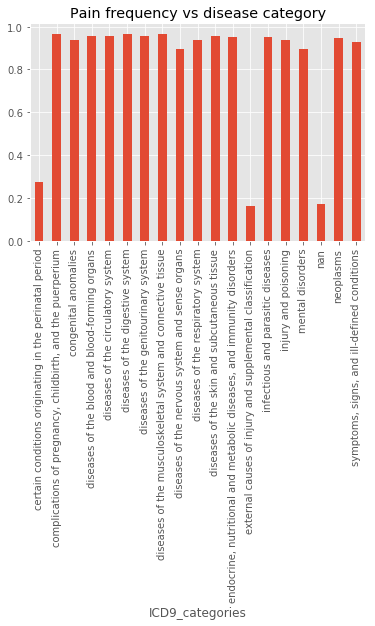

In [358]:
adm_per_type = Data.groupby(['ICD9_categories'])['hadm_id'].nunique()
a = (Data.groupby(['ICD9_categories','hadm_id'])['Pain_no_Pain'].sum()>0).groupby(['ICD9_categories']).sum()/ adm_per_type
a.plot(kind ='bar', title = 'Pain frequency vs disease category')

In [359]:
AgonyCount = Data.text.str.lower().str.count('agony')
Data['AgonyCount'] = AgonyCount

# the 'Pain_no_Pain' col indicates where pain is mentioned or not (binary)
Data['Agony_no_Agony'] = AgonyCount>0

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


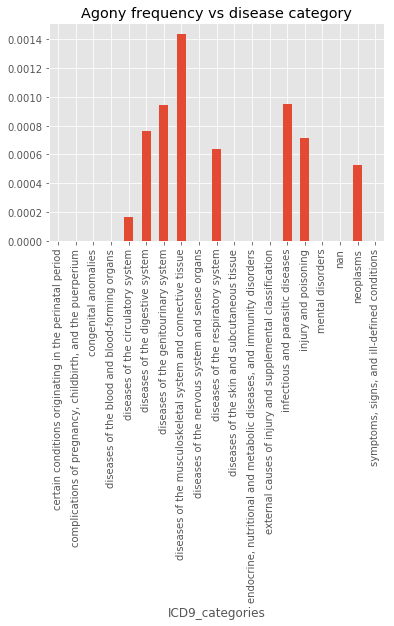

In [360]:
adm_per_type = Data.groupby(['ICD9_categories'])['hadm_id'].nunique()
a = (Data.groupby(['ICD9_categories','hadm_id'])['Agony_no_Agony'].sum()>0).groupby(['ICD9_categories']).sum()/ adm_per_type
a.plot(kind ='bar', title = 'Agony frequency vs disease category')

In [455]:
def Frequency(Data, word, GroupBy_word):
    wordCount = Data.text.str.lower().str.count(word.lower())
#     Data['Count'] = wordCount

    # the 'Pain_no_Pain' col indicates where pain is mentioned or not (binary)
    Data['word_no_word'] = wordCount>0

    adm_per_type = Data.groupby([GroupBy_word])['hadm_id'].nunique()
    a = (Data.groupby([GroupBy_word,'hadm_id'])['word_no_word'].sum()>0).groupby([GroupBy_word]).sum()/ adm_per_type
    a.plot(kind ='bar', title = '%s frequency vs %s'%(word, GroupBy_word))

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


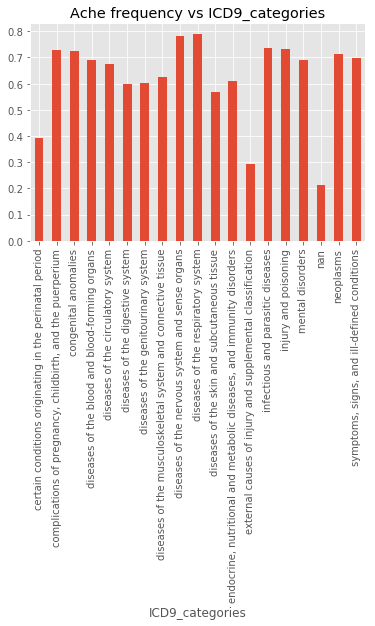

In [456]:
Frequency(Data, 'Ache', 'ICD9_categories')

/home/asamadan/anaconda3/envs/HST953/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'hadm_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


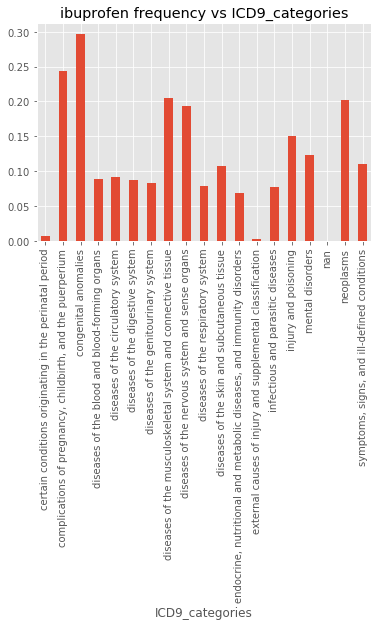

In [457]:
Frequency(Data, 'ibuprofen', 'ICD9_categories')



FF vs NFF

    This function takes admission for a subject and determines whether the subject is a FF or NFF

m

In [388]:
def SubjectCheck(subject):
    data = None
    NFF = 0
    if len(subject) > 2:
        Admission_Time = subject.admittime
        # gaps between every second admissions
        Inter_Admission_Gaps = np.array([(Admission_Time.iloc[x+2]-Admission_Time.iloc[x])/np.timedelta64(1, 'D')
         for x in range(len(subject)-2)] )       

        # for FF, we take their first admission
        if sum(Inter_Admission_Gaps<365):
            # take the first ICU admisson
            # appending the label to the end of the array
            return np.append(subject.iloc[np.where(Inter_Admission_Gaps<365)[0][0]].values, 1)
        else: # not a FF
            NFF = 1
    
    if len(subject) < 2 or NFF:
        # check if the patient is still alive
        if not(subject.expire_flag.iloc[0]):
            # appending the label to the end of the array
            return np.append(subject.iloc[0].values, 0)
#         else: 
#             data = None
#     return data
        
DATA = {}        
for subject, subject_data in Data.groupby('subject_id'):
     
    DATA[subject] = SubjectCheck(subject_data)
    
# convert dictionary to dataframe and label as the last column
DATA = dict((key,x) for key,x in DATA.items() if x is not None)
a = pd.DataFrame.from_dict(DATA, orient='index')
a.columns = np.append(Data.columns, 'Label')    

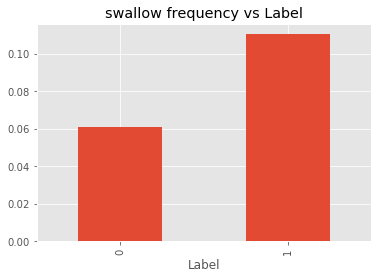

In [461]:
Frequency(a, 'swallow', 'Label')

In [420]:
b = pd.merge(Data, a[['subject_id', 'Label']], on='subject_id')
# remove neonates
b = b.loc[b.Age != 1]

In [ ]:
Frequency(b, 'pain','Labe')

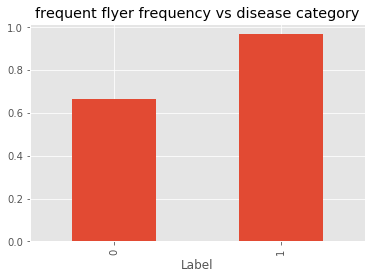

In [452]:
swallowCount = b.text.str.lower().str.count('pain')
b['swallowCount'] = swallowCount

# the 'Pain_no_Pain' col indicates where pain is mentioned or not (binary)
b['swallow_no_swallow'] = swallowCount>0

adm_per_type = b.groupby(['Label'])['subject_id'].nunique()
c = (b.groupby(['Label','subject_id'])['swallow_no_swallow'].sum()>0).groupby(['Label']).sum()/ adm_per_type
c.plot(kind ='bar', title = 'frequent flyer frequency vs disease category')